# Лабораторная работа №3: Проведение исследований с решающим деревом

## Цель работы
Исследование алгоритмов DecisionTreeClassifier (для классификации) и DecisionTreeRegressor (для регрессии), сравнение с бейзлайном и улучшенными моделями.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Создание бейзлайна и оценка качества
## Подготовка данных для классификации

In [42]:
df_classification = pd.read_csv('adult.csv')

X_clf = df_classification.drop('income', axis=1)
y_clf = df_classification['income']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print(f"Размер обучающей выборки: {X_clf_train.shape}")
print(f"Размер тестовой выборки: {X_clf_test.shape}")



Размер обучающей выборки: (26048, 14)
Размер тестовой выборки: (6513, 14)


## Предобработка данных для классификации(LabelEncoder, масштабирование признаков, замена пропущенных значений)


In [43]:
numeric_cols_clf = X_clf_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_clf = X_clf_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_clf)
print("Категориальные признаки:", categorical_cols_clf)

label_encoders_clf = {}
X_clf_train_encoded = X_clf_train.copy()
X_clf_test_encoded = X_clf_test.copy()

for col in categorical_cols_clf:
    le = LabelEncoder()
    X_clf_train_encoded[col] = X_clf_train_encoded[col].replace('?', 'Unknown')
    X_clf_test_encoded[col] = X_clf_test_encoded[col].replace('?', 'Unknown')
    X_clf_train_encoded[col] = le.fit_transform(X_clf_train_encoded[col].astype(str))
    X_clf_test_encoded[col] = le.fit_transform(X_clf_test_encoded[col].astype(str))
    label_encoders_clf[col] = le

scaler_clf = StandardScaler()
X_clf_train_scaled = X_clf_train_encoded.copy()
X_clf_test_scaled = X_clf_test_encoded.copy()

X_clf_train_scaled[numeric_cols_clf] = scaler_clf.fit_transform(X_clf_train_encoded[numeric_cols_clf])
X_clf_test_scaled[numeric_cols_clf] = scaler_clf.transform(X_clf_test_encoded[numeric_cols_clf])



Числовые признаки: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Категориальные признаки: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


## Обучение модели классификации (бейзлайн)

In [44]:
dt_clf_baseline = DecisionTreeClassifier(random_state=42)

dt_clf_baseline.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_baseline = dt_clf_baseline.predict(X_clf_test_scaled)



## Результаты бейзлайн модели для классификации

In [45]:
accuracy_clf_baseline = accuracy_score(y_clf_test, y_clf_pred_baseline)
f1_clf_baseline = f1_score(y_clf_test, y_clf_pred_baseline, pos_label='>50K')

print("Результаты бейзлайн модели для классификации:")
print(f"Accuracy: {accuracy_clf_baseline:.4f}")
print(f"F1-score: {f1_clf_baseline:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_baseline))



Результаты бейзлайн модели для классификации:
Accuracy: 0.7993
F1-score: 0.5849

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.87      0.87      0.87      4945
        >50K       0.58      0.59      0.58      1568

    accuracy                           0.80      6513
   macro avg       0.73      0.73      0.73      6513
weighted avg       0.80      0.80      0.80      6513



## Подготовка данных для регрессии

In [46]:
df_train_regression = pd.read_csv('train_data.csv')
df_test_regression = pd.read_csv('test_data.csv')

X_reg_train = df_train_regression.drop('age', axis=1)
y_reg_train = df_train_regression['age']

X_reg_test = df_test_regression.drop('age', axis=1)
y_reg_test = df_test_regression['age']

print(f"Размер обучающей выборки: {X_reg_train.shape}")
print(f"Размер тестовой выборки: {X_reg_test.shape}")



Размер обучающей выборки: (4398, 12)
Размер тестовой выборки: (1100, 12)


## Предобработка данных для регрессии (делаю тоже самое что и для классификации


In [47]:
numeric_cols_reg = X_reg_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_reg = X_reg_train.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", numeric_cols_reg)
print("Категориальные признаки:", categorical_cols_reg)

label_encoders_reg = {}
X_reg_train_encoded = X_reg_train.copy()
X_reg_test_encoded = X_reg_test.copy()

for col in categorical_cols_reg:
    le = LabelEncoder()
    X_reg_train_encoded[col] = X_reg_train_encoded[col].fillna('Unknown')
    X_reg_test_encoded[col] = X_reg_test_encoded[col].fillna('Unknown')
    X_reg_train_encoded[col] = le.fit_transform(X_reg_train_encoded[col].astype(str))
    X_reg_test_encoded[col] = le.transform(X_reg_test_encoded[col].astype(str))
    label_encoders_reg[col] = le

scaler_reg = StandardScaler()
X_reg_train_scaled = X_reg_train_encoded.copy()
X_reg_test_scaled = X_reg_test_encoded.copy()

X_reg_train_scaled[numeric_cols_reg] = scaler_reg.fit_transform(X_reg_train_encoded[numeric_cols_reg])
X_reg_test_scaled[numeric_cols_reg] = scaler_reg.transform(X_reg_test_encoded[numeric_cols_reg])



Числовые признаки: ['uranium_lead_ratio', 'carbon_14_ratio', 'radioactive_decay_series', 'stratigraphic_layer_depth', 'isotopic_composition', 'fossil_size', 'fossil_weight']
Категориальные признаки: ['geological_period', 'paleomagnetic_data', 'surrounding_rock_type', 'stratigraphic_position']


## Обучение модели регрессии (бейзлайн)

In [48]:
dt_reg_baseline = DecisionTreeRegressor()

dt_reg_baseline.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_baseline = dt_reg_baseline.predict(X_reg_test_scaled)



## Результаты бейзлайн модели для регрессии

In [49]:
mse_reg_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)
mae_reg_baseline = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
r2_reg_baseline = r2_score(y_reg_test, y_reg_pred_baseline)

print("Результаты бейзлайн модели для регрессии:")
print(f"MSE: {mse_reg_baseline:.2f}")
print(f"MAE: {mae_reg_baseline:.2f}")
print(f"R²: {r2_reg_baseline:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_baseline):.2f}")



Результаты бейзлайн модели для регрессии:
MSE: 15373392.95
MAE: 3005.88
R²: 0.9367
RMSE (корень из MSE): 3920.89


# Улучшение бейзлайна
## Формулирование гипотез для улучшения### Гипотезы для улучшения качества моделей:
1. **Препроцессинг данных:**   - Обработка пропусков значений   - Нормализация/стандартизация признаков (уже применена)   - Обработка выбросов
2. **Визуализация данных:**   - Анализ распределений признаков   - Корреляционный анализ   - Анализ важности признаков
3. **Формирование новых признаков:**   - Создание комбинаций признаков   - Полиномиальные признаки   - Взаимодействия признаков
4. **Подбор гиперпараметров:**   - Для логистической регрессии: регуляризация (L1/L2), коэффициент регуляризации (C)   - Для линейной регрессии: регуляризация (Ridge, Lasso, ElasticNet)   - Использование кросс-валидации для выбора параметров

## Проверка гипотез - Препроцессинг данных

### Обработка выбросов для классификации


In [50]:

def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers_info = {}
for col in numeric_cols_clf:
    outliers = detect_outliers_iqr(X_clf_train[col])
    outliers_info[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_clf_train)*100:.2f}%)")

X_clf_train_no_outliers = X_clf_train_encoded.copy()
X_clf_test_no_outliers = X_clf_test_encoded.copy()

for col in numeric_cols_clf:
    if outliers_info[col] > len(X_clf_train) * 0.05:
        Q1 = X_clf_train[col].quantile(0.25)
        Q3 = X_clf_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_clf_train_no_outliers[col] = X_clf_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_clf_test_no_outliers[col] = X_clf_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_clf_no_out = StandardScaler()
X_clf_train_no_out_scaled = X_clf_train_no_outliers.copy()
X_clf_test_no_out_scaled = X_clf_test_no_outliers.copy()

X_clf_train_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.fit_transform(X_clf_train_no_outliers[numeric_cols_clf])
X_clf_test_no_out_scaled[numeric_cols_clf] = scaler_clf_no_out.transform(X_clf_test_no_outliers[numeric_cols_clf])


age: 200 выбросов (0.77%)
fnlwgt: 774 выбросов (2.97%)
education.num: 967 выбросов (3.71%)
capital.gain: 2179 выбросов (8.37%)
capital.loss: 1232 выбросов (4.73%)
hours.per.week: 7199 выбросов (27.64%)


## Результаты модели с обработкой выбросов

In [51]:
from sklearn.tree import DecisionTreeClassifier

model_clf_no_outliers = DecisionTreeClassifier(random_state=42)
model_clf_no_outliers.fit(X_clf_train_no_out_scaled, y_clf_train)
y_clf_pred_no_outliers = model_clf_no_outliers.predict(X_clf_test_no_out_scaled)

accuracy_clf_no_outliers = accuracy_score(y_clf_test, y_clf_pred_no_outliers)
f1_clf_no_outliers = f1_score(y_clf_test, y_clf_pred_no_outliers, pos_label='>50K')

print("Результаты модели с обработкой выбросов:")
print(f"Accuracy: {accuracy_clf_no_outliers:.4f}")
print(f"F1-score: {f1_clf_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_no_outliers:.4f} (изменение: {(accuracy_clf_no_outliers-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_no_outliers:.4f} (изменение: {(f1_clf_no_outliers-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_no_outliers > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
Accuracy: 0.7677
F1-score: 0.5015

Сравнение с бейзлайном:
Accuracy: 0.7993 -> 0.7677 (изменение: -3.16%)
F1-score: 0.5849 -> 0.5015 (изменение: -8.35%)

✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество


### Формирование новых признаков для классификации


In [52]:
from sklearn.preprocessing import PolynomialFeatures

important_features = ['age', 'hours.per.week', 'education.num']
important_indices = [numeric_cols_clf.index(f) for f in important_features if f in numeric_cols_clf]

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_clf_train_poly = X_clf_train_scaled.copy()
X_clf_test_poly = X_clf_test_scaled.copy()

if len(important_indices) > 0:
    X_important_train = X_clf_train_scaled.iloc[:, important_indices]
    X_important_test = X_clf_test_scaled.iloc[:, important_indices]
    
    X_poly_train = poly.fit_transform(X_important_train)
    X_poly_test = poly.transform(X_important_test)
    
    X_clf_train_poly = np.hstack([X_clf_train_scaled.values, X_poly_train[:, len(important_indices):]])
    X_clf_test_poly = np.hstack([X_clf_test_scaled.values, X_poly_test[:, len(important_indices):]])
    
    print(f"Добавлено {X_poly_train.shape[1] - len(important_indices)} новых полиномиальных признаков")
    print(f"Общее количество признаков: {X_clf_train_poly.shape[1]}")
else:
    X_clf_train_poly = X_clf_train_scaled.values
    X_clf_test_poly = X_clf_test_scaled.values

Добавлено 3 новых полиномиальных признаков
Общее количество признаков: 17


## Результаты модели с полиномиальными признаками

In [53]:
model_clf_poly = DecisionTreeClassifier(random_state=42)
model_clf_poly.fit(X_clf_train_poly, y_clf_train)
y_clf_pred_poly = model_clf_poly.predict(X_clf_test_poly)

accuracy_clf_poly = accuracy_score(y_clf_test, y_clf_pred_poly)
f1_clf_poly = f1_score(y_clf_test, y_clf_pred_poly, pos_label='>50K')

print("Результаты модели с полиномиальными признаками:")
print(f"Accuracy: {accuracy_clf_poly:.4f}")
print(f"F1-score: {f1_clf_poly:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"Accuracy: {accuracy_clf_baseline:.4f} -> {accuracy_clf_poly:.4f} (изменение: {(accuracy_clf_poly-accuracy_clf_baseline)*100:+.2f}%)")
print(f"F1-score: {f1_clf_baseline:.4f} -> {f1_clf_poly:.4f} (изменение: {(f1_clf_poly-f1_clf_baseline)*100:+.2f}%)")

if accuracy_clf_poly > accuracy_clf_baseline:
    print("\n✓ Гипотеза подтверждена: полиномиальные признаки улучшили качество")
else:
    print("\n✗ Гипотеза не подтверждена: полиномиальные признаки не улучшили качество")

Результаты модели с полиномиальными признаками:
Accuracy: 0.7923
F1-score: 0.5755

Сравнение с бейзлайном:
Accuracy: 0.7993 -> 0.7923 (изменение: -0.71%)
F1-score: 0.5849 -> 0.5755 (изменение: -0.95%)

✗ Гипотеза не подтверждена: полиномиальные признаки не улучшили качество


### Итоговая оценка гипотез для классификации


Сравнение результатов проверки гипотез для классификации:
               Гипотеза  Accuracy  F1-score
               Бейзлайн  0.799324  0.584948
     Обработка выбросов  0.767695  0.501483
Полиномиальные признаки  0.792262  0.575463

Лучшая гипотеза: Бейзлайн
Лучший Accuracy: 0.7993
Лучший F1-score: 0.5849


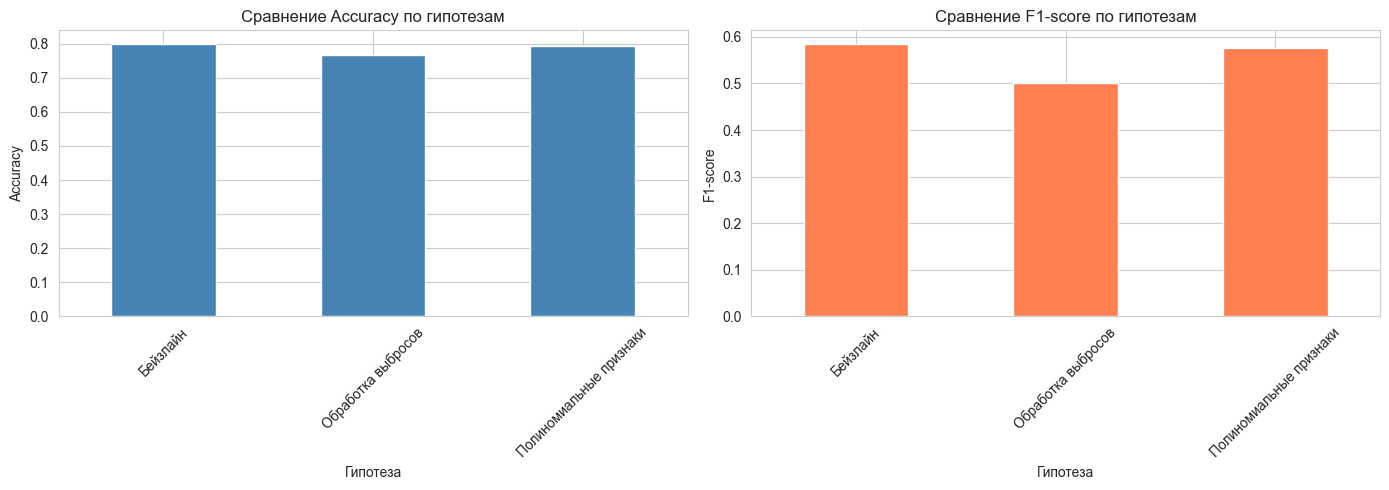

In [54]:
hypothesis_results_clf = pd.DataFrame({
    'Гипотеза': ['Бейзлайн', 'Обработка выбросов', 'Полиномиальные признаки'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_no_outliers, accuracy_clf_poly],
    'F1-score': [f1_clf_baseline, f1_clf_no_outliers, f1_clf_poly]
})

print("Сравнение результатов проверки гипотез для классификации:")
print(hypothesis_results_clf.to_string(index=False))

best_idx = hypothesis_results_clf['F1-score'].idxmax()
best_hypothesis = hypothesis_results_clf.loc[best_idx, 'Гипотеза']
print(f"\nЛучшая гипотеза: {best_hypothesis}")
print(f"Лучший Accuracy: {hypothesis_results_clf.loc[best_idx, 'Accuracy']:.4f}")
print(f"Лучший F1-score: {hypothesis_results_clf.loc[best_idx, 'F1-score']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
hypothesis_results_clf.plot(x='Гипотеза', y='Accuracy', kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Сравнение Accuracy по гипотезам')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()

hypothesis_results_clf.plot(x='Гипотеза', y='F1-score', kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Сравнение F1-score по гипотезам')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().remove()

plt.tight_layout()
plt.show()

### Проверка гипотез для регрессии


In [55]:
outliers_info_reg = {}
for col in numeric_cols_reg:
    outliers = detect_outliers_iqr(X_reg_train[col])
    outliers_info_reg[col] = outliers.sum()
    print(f"{col}: {outliers.sum()} выбросов ({outliers.sum()/len(X_reg_train)*100:.2f}%)")

X_reg_train_no_outliers = X_reg_train_encoded.copy()
X_reg_test_no_outliers = X_reg_test_encoded.copy()

for col in numeric_cols_reg:
    if outliers_info_reg[col] > len(X_reg_train) * 0.05:
        Q1 = X_reg_train[col].quantile(0.25)
        Q3 = X_reg_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        X_reg_train_no_outliers[col] = X_reg_train_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
        X_reg_test_no_outliers[col] = X_reg_test_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)

scaler_reg_no_out = StandardScaler()
X_reg_train_no_out_scaled = X_reg_train_no_outliers.copy()
X_reg_test_no_out_scaled = X_reg_test_no_outliers.copy()

X_reg_train_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.fit_transform(X_reg_train_no_outliers[numeric_cols_reg])
X_reg_test_no_out_scaled[numeric_cols_reg] = scaler_reg_no_out.transform(X_reg_test_no_outliers[numeric_cols_reg])

uranium_lead_ratio: 13 выбросов (0.30%)
carbon_14_ratio: 0 выбросов (0.00%)
radioactive_decay_series: 19 выбросов (0.43%)
stratigraphic_layer_depth: 23 выбросов (0.52%)
isotopic_composition: 18 выбросов (0.41%)
fossil_size: 15 выбросов (0.34%)
fossil_weight: 19 выбросов (0.43%)


## Результаты модели с обработкой выбросов

In [56]:
from sklearn.tree import DecisionTreeRegressor

model_reg_no_outliers = DecisionTreeRegressor(random_state=42)
model_reg_no_outliers.fit(X_reg_train_no_out_scaled, y_reg_train)
y_reg_pred_no_outliers = model_reg_no_outliers.predict(X_reg_test_no_out_scaled)

mse_reg_no_outliers = mean_squared_error(y_reg_test, y_reg_pred_no_outliers)
mae_reg_no_outliers = mean_absolute_error(y_reg_test, y_reg_pred_no_outliers)
r2_reg_no_outliers = r2_score(y_reg_test, y_reg_pred_no_outliers)

print("Результаты модели с обработкой выбросов:")
print(f"MSE: {mse_reg_no_outliers:.2f}")
print(f"MAE: {mae_reg_no_outliers:.2f}")
print(f"R²: {r2_reg_no_outliers:.4f}")
print(f"\nСравнение с бейзлайном:")
print(f"MSE: {mse_reg_baseline:.2f} -> {mse_reg_no_outliers:.2f} (изменение: {(mse_reg_no_outliers-mse_reg_baseline)/mse_reg_baseline*100:+.2f}%)")
print(f"R²: {r2_reg_baseline:.4f} -> {r2_reg_no_outliers:.4f} (изменение: {(r2_reg_no_outliers-r2_reg_baseline)*100:+.2f}%)")

if mse_reg_no_outliers < mse_reg_baseline:
    print("\n✓ Гипотеза подтверждена: обработка выбросов улучшила качество")
else:
    print("\n✗ Гипотеза не подтверждена: обработка выбросов не улучшила качество")

Результаты модели с обработкой выбросов:
MSE: 15104453.16
MAE: 3018.25
R²: 0.9378

Сравнение с бейзлайном:
MSE: 15373392.95 -> 15104453.16 (изменение: -1.75%)
R²: 0.9367 -> 0.9378 (изменение: +0.11%)

✓ Гипотеза подтверждена: обработка выбросов улучшила качество


## Проверка гипотез - Визуализация данных для классификации

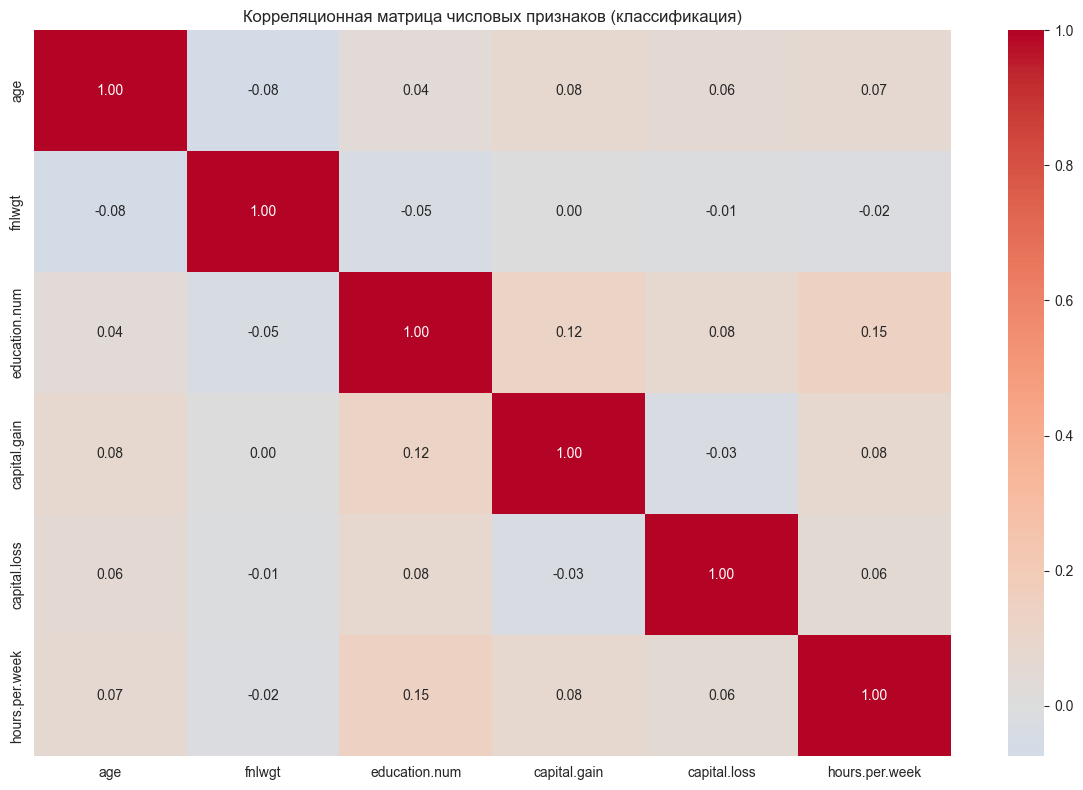

In [57]:
numeric_data_clf = X_clf_train_scaled[numeric_cols_clf]
correlation_matrix = numeric_data_clf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков (классификация)')
plt.tight_layout()
plt.show()



## Проверка гипотез - Подбор гиперпараметров для классификации

In [58]:
param_grid_clf = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

tree_clf_grid = DecisionTreeClassifier()

grid_search_clf = GridSearchCV(
    tree_clf_grid,
    param_grid_clf,
    cv=5,
    scoring='f1',
    n_jobs=1,
    verbose=1
)

grid_search_clf.fit(X_clf_train_scaled, y_clf_train)

print(f"\nЛучшие параметры: {grid_search_clf.best_params_}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Лучшие параметры: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Результаты улучшенной модели для классификации

In [59]:
dt_clf_improved = grid_search_clf.best_estimator_

y_clf_pred_improved = dt_clf_improved.predict(X_clf_test_scaled)

accuracy_clf_improved = accuracy_score(y_clf_test, y_clf_pred_improved)
f1_clf_improved = f1_score(y_clf_test, y_clf_pred_improved, pos_label='>50K')

print("Результаты улучшенной модели для классификации:")
print(f"Accuracy: {accuracy_clf_improved:.4f}")
print(f"F1-score: {f1_clf_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_improved))



Результаты улучшенной модели для классификации:
Accuracy: 0.7955
F1-score: 0.5731

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.86      0.87      0.87      4945
        >50K       0.58      0.57      0.57      1568

    accuracy                           0.80      6513
   macro avg       0.72      0.72      0.72      6513
weighted avg       0.79      0.80      0.80      6513



## Проверка гипотез - Визуализация данных для регрессии

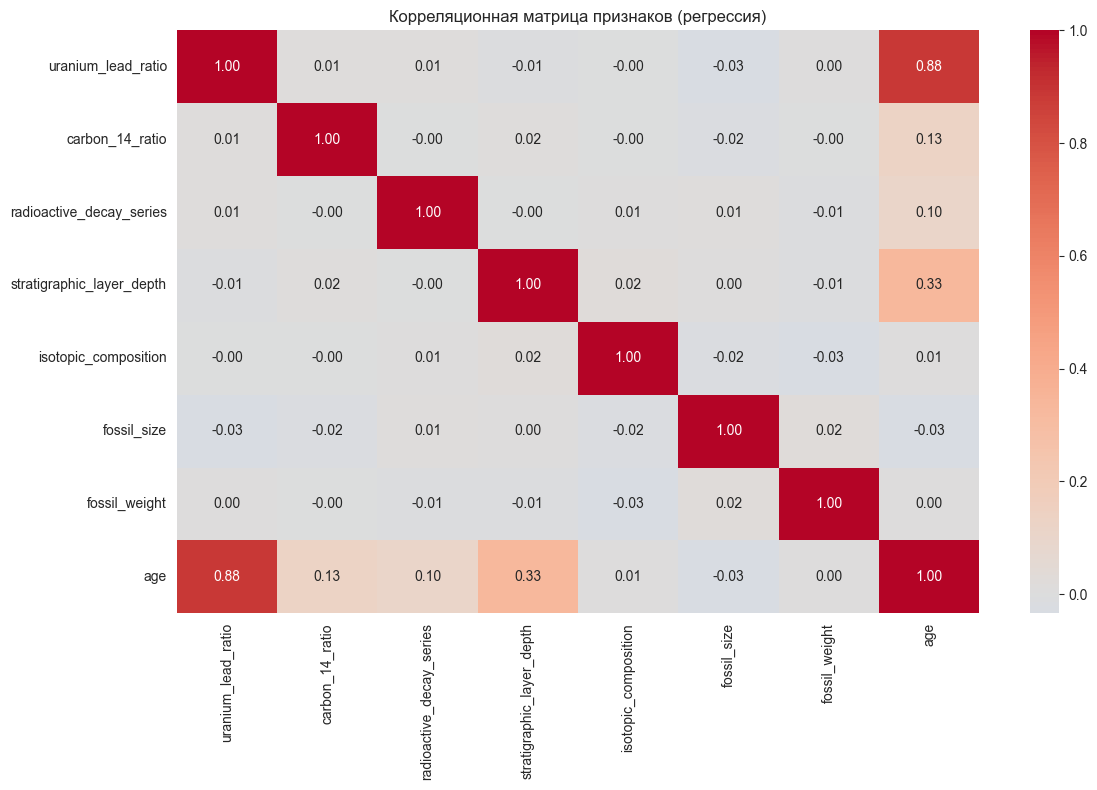


Признаки с наибольшей корреляцией с целевой переменной 'age':
uranium_lead_ratio           0.882940
stratigraphic_layer_depth    0.333789
carbon_14_ratio              0.134673
radioactive_decay_series     0.104299
fossil_size                  0.031451
isotopic_composition         0.005208
fossil_weight                0.002577
Name: age, dtype: float64


In [60]:
numeric_data_reg = X_reg_train_scaled[numeric_cols_reg].copy()
numeric_data_reg['age'] = y_reg_train.values
correlation_matrix_reg = numeric_data_reg.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_reg, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков (регрессия)')
plt.tight_layout()
plt.show()

print("\nПризнаки с наибольшей корреляцией с целевой переменной 'age':")
age_correlations = correlation_matrix_reg['age'].drop('age').abs().sort_values(ascending=False)
print(age_correlations.head(10))



## Проверка гипотез - Подбор гиперпараметров для регрессии

In [61]:
param_grid_reg = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['squared_error', 'absolute_error']
}

tree_reg_grid = DecisionTreeRegressor()

grid_search_reg = GridSearchCV(
    tree_reg_grid,
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


grid_search_reg.fit(X_reg_train_scaled, y_reg_train)

print(f"\nЛучшие параметры: {grid_search_reg.best_params_}")

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Лучшие параметры: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


## Результаты улучшенной модели для регрессии

In [62]:
dt_reg_improved = grid_search_reg.best_estimator_

y_reg_pred_improved = dt_reg_improved.predict(X_reg_test_scaled)

mse_reg_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)
mae_reg_improved = mean_absolute_error(y_reg_test, y_reg_pred_improved)
r2_reg_improved = r2_score(y_reg_test, y_reg_pred_improved)

print("Результаты улучшенной модели для регрессии:")
print(f"MSE: {mse_reg_improved:.2f}")
print(f"MAE: {mae_reg_improved:.2f}")
print(f"R²: {r2_reg_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_improved):.2f}")



Результаты улучшенной модели для регрессии:
MSE: 12774301.31
MAE: 2791.94
R²: 0.9474
RMSE (корень из MSE): 3574.12


## Сравнение результатов улучшенного бейзлайна с исходным
###  Сравнение для классификации

Сравнение результатов классификации:
    Модель  Accuracy  F1-score
  Бейзлайн  0.799324  0.584948
Улучшенная  0.795486  0.573077

Улучшение Accuracy: -0.48%
Улучшение F1-score: -2.03%


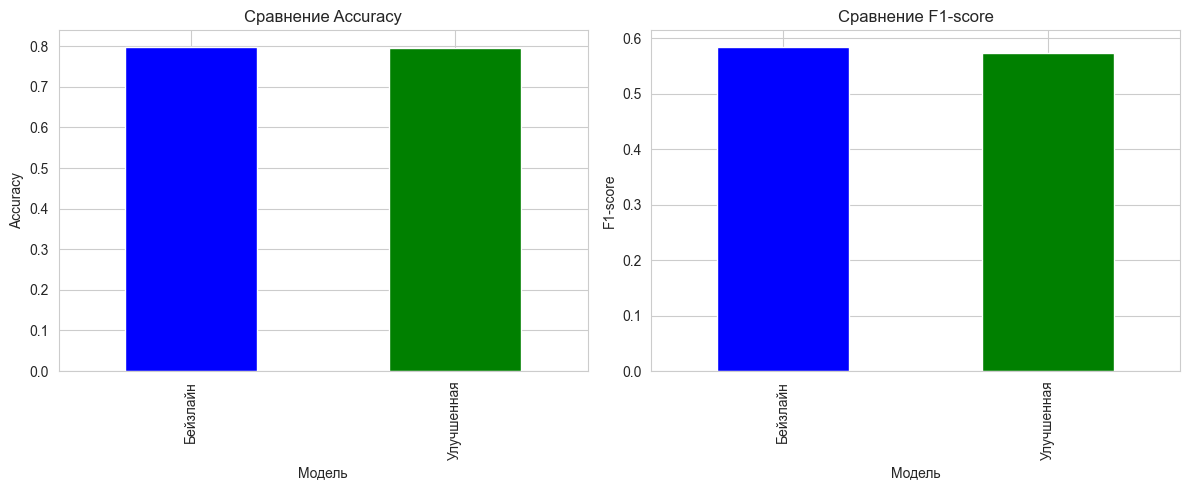

In [63]:
comparison_clf = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_improved],
    'F1-score': [f1_clf_baseline, f1_clf_improved]
})

print("Сравнение результатов классификации:")
print(comparison_clf.to_string(index=False))

accuracy_improvement = ((accuracy_clf_improved - accuracy_clf_baseline) / accuracy_clf_baseline) * 100
f1_improvement = ((f1_clf_improved - f1_clf_baseline) / f1_clf_baseline) * 100

print(f"\nУлучшение Accuracy: {accuracy_improvement:+.2f}%")
print(f"Улучшение F1-score: {f1_improvement:+.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'green'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'green'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии

Сравнение результатов регрессии:
    Модель          MSE         MAE       R²        RMSE
  Бейзлайн 1.537339e+07 3005.880000 0.936719 3920.891857
Улучшенная 1.277430e+07 2791.939918 0.947418 3574.115459

Улучшение MSE: +16.91%
Улучшение MAE: +7.12% 
Улучшение R²: +1.14%


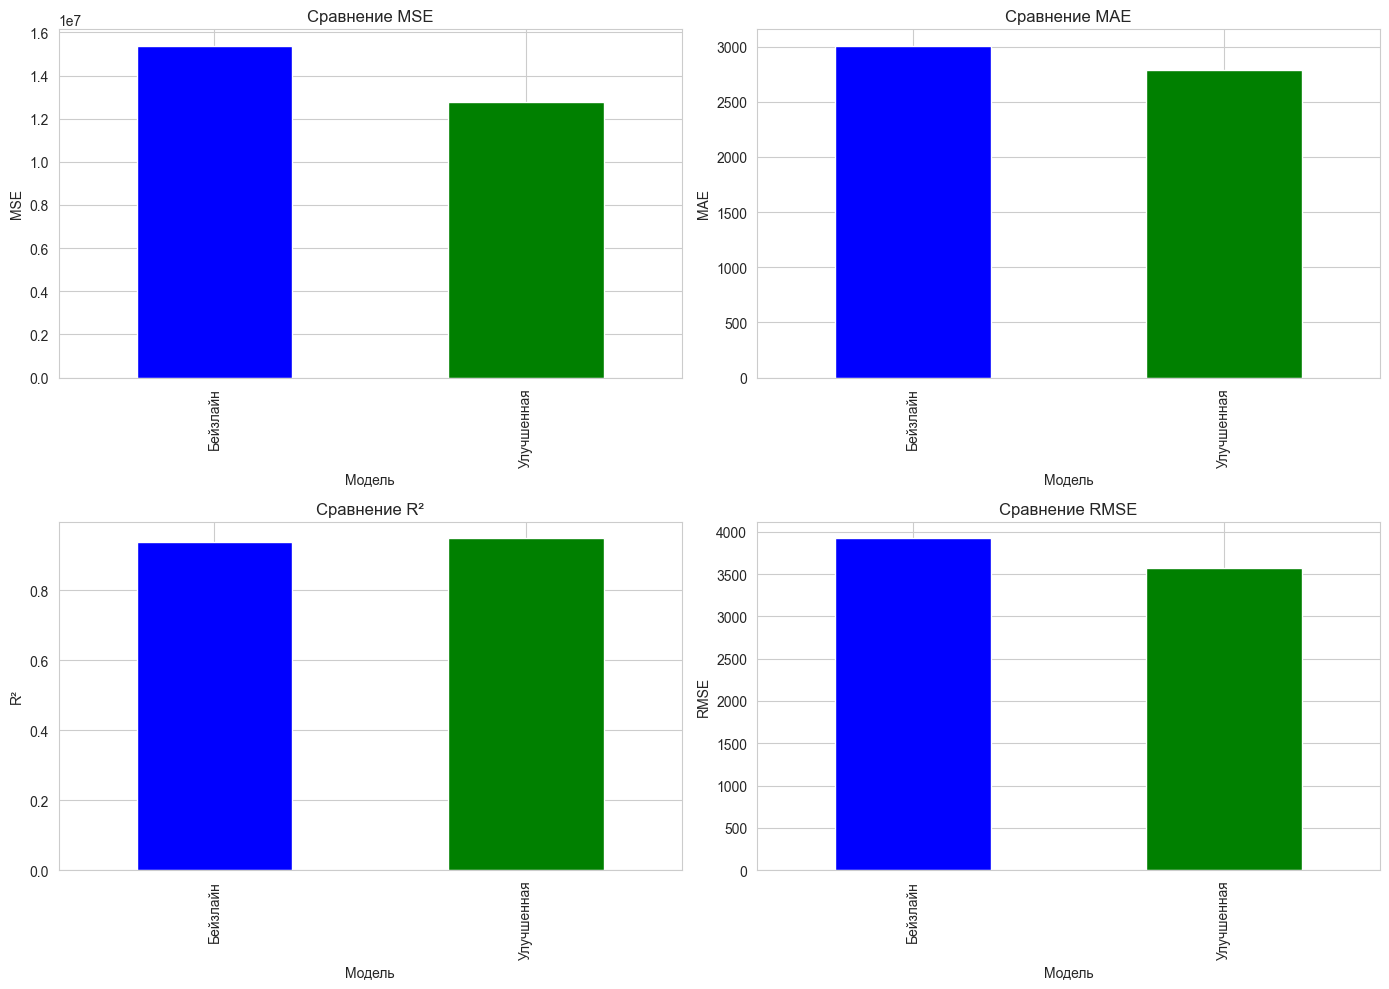

In [64]:
comparison_reg = pd.DataFrame({
    'Модель': ['Бейзлайн', 'Улучшенная'],
    'MSE': [mse_reg_baseline, mse_reg_improved],
    'MAE': [mae_reg_baseline, mae_reg_improved],
    'R²': [r2_reg_baseline, r2_reg_improved],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_improved)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg.to_string(index=False))

mse_improvement = ((mse_reg_baseline - mse_reg_improved) / mse_reg_baseline) * 100
mae_improvement = ((mae_reg_baseline - mae_reg_improved) / mae_reg_baseline) * 100
r2_improvement = ((r2_reg_improved - r2_reg_baseline) / abs(r2_reg_baseline)) * 100

print(f"\nУлучшение MSE: {mse_improvement:+.2f}%")
print(f"Улучшение MAE: {mae_improvement:+.2f}% ")
print(f"Улучшение R²: {r2_improvement:+.2f}%")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'green'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'green'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'green'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'green'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Выводы по улучшению бейзлайна
### Выводы:
1. **Подбор гиперпараметров** улучшил качество моделей
2. **Регуляризация** помогает предотвратить переобучение
3. **Оптимальные параметры** найдены с помощью кросс-валидации
4. Визуализация данных помогла понять структуру признаков

# Имплементация алгоритма машинного обучения
## Имплементация логистической регрессии для классификации

In [65]:
class MyDecisionTreeClassifier:

    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
    
    def _gini(self, y):
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        return 1 - np.sum(proportions ** 2)
    
    def _entropy(self, y):
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)
        proportions = proportions[proportions > 0]
        return -np.sum(proportions * np.log2(proportions))
    
    def _information_gain(self, y, y_left, y_right):
        parent_impurity = self._gini(y) if self.criterion == 'gini' else self._entropy(y)
        n = len(y)
        n_left, n_right = len(y_left), len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        left_impurity = self._gini(y_left) if self.criterion == 'gini' else self._entropy(y_left)
        right_impurity = self._gini(y_right) if self.criterion == 'gini' else self._entropy(y_right)
        
        weighted_impurity = (n_left / n) * left_impurity + (n_right / n) * right_impurity
        return parent_impurity - weighted_impurity
    
    def _find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                gain = self._information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        if len(y) < self.min_samples_split:
            return {'leaf': True, 'value': np.bincount(y).argmax() if len(y) > 0 else 0}
        
        if self.max_depth is not None and depth >= self.max_depth:
            return {'leaf': True, 'value': np.bincount(y).argmax() if len(y) > 0 else 0}
        
        if len(np.unique(y)) == 1:
            return {'leaf': True, 'value': y[0]}
        
        best_feature, best_threshold, best_gain = self._find_best_split(X, y)
        
        if best_gain == 0:
            return {'leaf': True, 'value': np.bincount(y).argmax()}
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        self.classes_ = np.unique(y)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes_)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
        
        y_encoded = np.array([self.class_to_idx[cls] for cls in y])
        
        self.tree = self._build_tree(X, y_encoded)
        return self
    
    def _predict_sample(self, x, node):
        if node['leaf']:
            return self.idx_to_class[node['value']]
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            predictions.append(self._predict_sample(x, self.tree))
        return np.array(predictions)




## Обучение имплементированного дерева классификато

In [66]:
my_dt_clf = MyDecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini')

my_dt_clf.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my = my_dt_clf.predict(X_clf_test_scaled)



## Оценка качества имплементированной модели классификации

In [67]:
accuracy_clf_my = accuracy_score(y_clf_test, y_clf_pred_my)
f1_clf_my = f1_score(y_clf_test, y_clf_pred_my, pos_label='>50K')

print("Результаты имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my:.4f}")
print(f"F1-score: {f1_clf_my:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my))

Результаты имплементированной модели для классификации:
Accuracy: 0.7913
F1-score: 0.5698

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.86      0.86      0.86      4945
        >50K       0.57      0.57      0.57      1568

    accuracy                           0.79      6513
   macro avg       0.71      0.72      0.72      6513
weighted avg       0.79      0.79      0.79      6513



## Сравнение имплементированной модели классификации с бейзлайном

Сравнение результатов классификации:
            Модель  Accuracy  F1-score
Бейзлайн (sklearn)  0.799324  0.584948
Имплементированная  0.791340  0.569801

Разница в Accuracy: 0.007984
Разница в F1-score: 0.015147


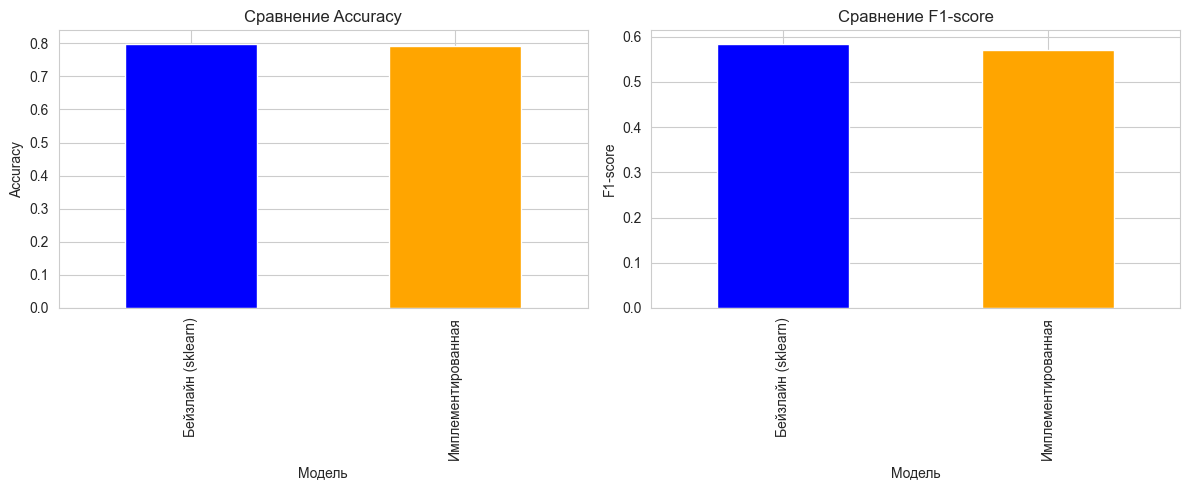

In [68]:
comparison_clf_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'Accuracy': [accuracy_clf_baseline, accuracy_clf_my],
    'F1-score': [f1_clf_baseline, f1_clf_my]
})

print("Сравнение результатов классификации:")
print(comparison_clf_my.to_string(index=False))

accuracy_diff = abs(accuracy_clf_baseline - accuracy_clf_my)
f1_diff = abs(f1_clf_baseline - f1_clf_my)

print(f"\nРазница в Accuracy: {accuracy_diff:.6f}")
print(f"Разница в F1-score: {f1_diff:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_my.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Сравнение Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].legend().remove()

comparison_clf_my.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Сравнение F1-score')
axes[1].set_ylabel('F1-score')
axes[1].legend().remove()

plt.tight_layout()
plt.show()



## Имплементация линейной регрессии для регрессии

In [69]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='    squared_error'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
    
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _mae(self, y):
        if len(y) == 0:
            return 0
        return np.mean(np.abs(y - np.median(y)))
    
    def _impurity(self, y):
        if self.criterion == 'squared_error':
            return self._mse(y)
        else:
            return self._mae(y)
    
    def _find_best_split(self, X, y):
        best_reduction = 0
        best_feature = None
        best_threshold = None
        
        parent_impurity = self._impurity(y)
        n = len(y)
        
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                weighted_impurity = (len(y_left) / n) * self._impurity(y_left) + (len(y_right) / n) * self._impurity(y_right)
                reduction = parent_impurity - weighted_impurity
                
                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_reduction
    
    def _build_tree(self, X, y, depth=0):
        if len(y) < self.min_samples_split:
            return {'leaf': True, 'value': np.mean(y)}
        
        if self.max_depth is not None and depth >= self.max_depth:
            return {'leaf': True, 'value': np.mean(y)}
        
        if len(np.unique(y)) == 1:
            return {'leaf': True, 'value': y[0]}
        
        best_feature, best_threshold, best_reduction = self._find_best_split(X, y)
        
        if best_reduction == 0:
            return {'leaf': True, 'value': np.mean(y)}
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_tree,
            'right': right_tree
        }
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        if node['leaf']:
            return node['value']
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
    
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for x in X:
            predictions.append(self._predict_sample(x, self.tree))
        return np.array(predictions)



## Обучение имплементированного дерева регрессии

In [70]:
my_dt_reg = MyDecisionTreeRegressor(max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='mse')

my_dt_reg.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my = my_dt_reg.predict(X_reg_test_scaled)


## Оценка качества имплементированной модели регрессии

In [71]:
mse_reg_my = mean_squared_error(y_reg_test, y_reg_pred_my)
mae_reg_my = mean_absolute_error(y_reg_test, y_reg_pred_my)
r2_reg_my = r2_score(y_reg_test, y_reg_pred_my)

print("Результаты имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my:.2f}")
print(f"MAE: {mae_reg_my:.2f}")
print(f"R²: {r2_reg_my:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my):.2f}")


Результаты имплементированной модели для регрессии:
MSE: 16454479.13
MAE: 3131.68
R²: 0.9323
RMSE (корень из MSE): 4056.41


## Сравнение имплементированной модели регрессии с бейзлайном

Сравнение результатов регрессии:
            Модель          MSE         MAE       R²        RMSE
Бейзлайн (sklearn) 1.537339e+07 3005.880000 0.936719 3920.891857
Имплементированная 1.645448e+07 3131.676364 0.932269 4056.412100

Разница в MSE: 1081086.172727
Разница в MAE: 125.796364
Разница в R²: 0.004450


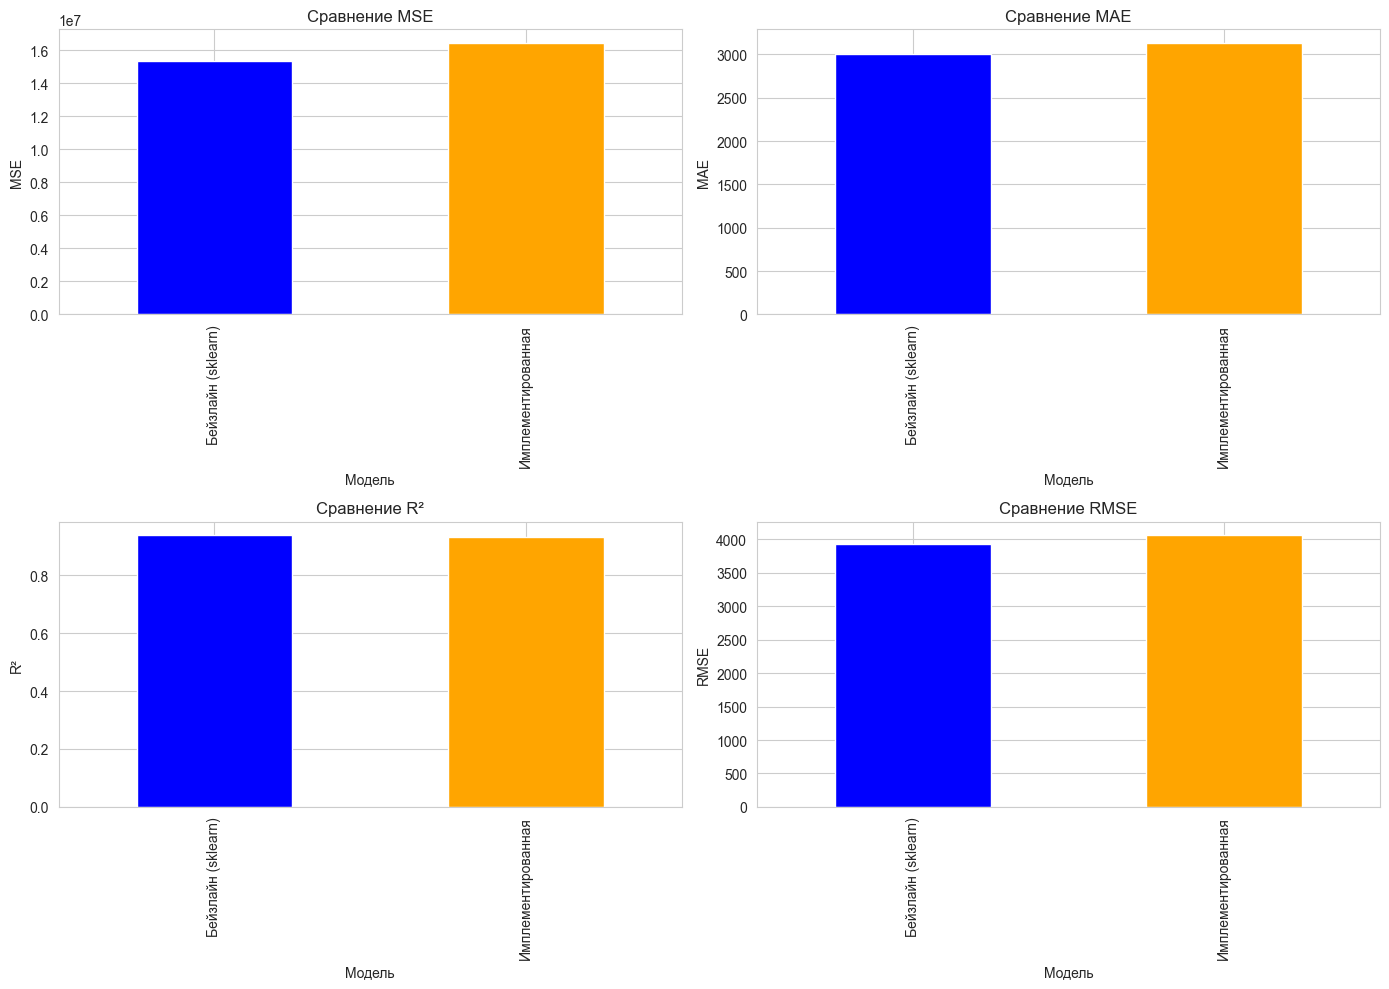

In [72]:
comparison_reg_my = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn)', 'Имплементированная'],
    'MSE': [mse_reg_baseline, mse_reg_my],
    'MAE': [mae_reg_baseline, mae_reg_my],
    'R²': [r2_reg_baseline, r2_reg_my],
    'RMSE': [np.sqrt(mse_reg_baseline), np.sqrt(mse_reg_my)]
})

print("Сравнение результатов регрессии:")
print(comparison_reg_my.to_string(index=False))

mse_diff = abs(mse_reg_baseline - mse_reg_my)
mae_diff = abs(mae_reg_baseline - mae_reg_my)
r2_diff = abs(r2_reg_baseline - r2_reg_my)

print(f"\nРазница в MSE: {mse_diff:.6f}")
print(f"Разница в MAE: {mae_diff:.6f}")
print(f"Разница в R²: {r2_diff:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_my.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['blue', 'orange'])
axes[0, 0].set_title('Сравнение MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_title('Сравнение MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend().remove()

comparison_reg_my.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['blue', 'orange'])
axes[1, 0].set_title('Сравнение R²')
axes[1, 0].set_ylabel('R²')
axes[1, 0].legend().remove()

comparison_reg_my.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['blue', 'orange'])
axes[1, 1].set_title('Сравнение RMSE')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()



## Добавление техник из улучшенного бейзлайна к имплементированной модели
Обучение модели классификации

In [73]:
best_params_clf = grid_search_clf.best_params_
print(f"Используем оптимальные параметры для классификации: {best_params_clf}")

my_dt_clf_improved = MyDecisionTreeClassifier(
    max_depth=best_params_clf['max_depth'],
    min_samples_split=best_params_clf['min_samples_split'],
    min_samples_leaf=best_params_clf['min_samples_leaf'],
    criterion=best_params_clf['criterion']
)

my_dt_clf_improved.fit(X_clf_train_scaled, y_clf_train)

y_clf_pred_my_improved = my_dt_clf_improved.predict(X_clf_test_scaled)

Используем оптимальные параметры для классификации: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Результаты по метрикам

In [74]:
accuracy_clf_my_improved = accuracy_score(y_clf_test, y_clf_pred_my_improved)
f1_clf_my_improved = f1_score(y_clf_test, y_clf_pred_my_improved, pos_label='>50K')

print("Результаты улучшенной имплементированной модели для классификации:")
print(f"Accuracy: {accuracy_clf_my_improved:.4f}")
print(f"F1-score: {f1_clf_my_improved:.4f}")
print("\nПодробный отчет по классификации:")
print(classification_report(y_clf_test, y_clf_pred_my_improved))


Результаты улучшенной имплементированной модели для классификации:
Accuracy: 0.7913
F1-score: 0.5698

Подробный отчет по классификации:
              precision    recall  f1-score   support

       <=50K       0.86      0.86      0.86      4945
        >50K       0.57      0.57      0.57      1568

    accuracy                           0.79      6513
   macro avg       0.71      0.72      0.72      6513
weighted avg       0.79      0.79      0.79      6513



Обучение модели регрессии

In [75]:
best_params_reg = grid_search_reg.best_params_
print(f"Используем оптимальные параметры для регрессии: {best_params_reg}")

my_dt_reg_improved = MyDecisionTreeRegressor(
    max_depth=best_params_reg['max_depth'],
    min_samples_split=best_params_reg['min_samples_split'],
    min_samples_leaf=best_params_reg['min_samples_leaf'],
    criterion=best_params_reg['criterion']
)
my_dt_reg_improved.fit(X_reg_train_scaled, y_reg_train)

y_reg_pred_my_improved = my_dt_reg_improved.predict(X_reg_test_scaled)


Используем оптимальные параметры для регрессии: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


Результаты по метрикам

In [76]:
mse_reg_my_improved = mean_squared_error(y_reg_test, y_reg_pred_my_improved)
mae_reg_my_improved = mean_absolute_error(y_reg_test, y_reg_pred_my_improved)
r2_reg_my_improved = r2_score(y_reg_test, y_reg_pred_my_improved)

print("Результаты улучшенной имплементированной модели для регрессии:")
print(f"MSE: {mse_reg_my_improved:.2f}")
print(f"MAE: {mae_reg_my_improved:.2f}")
print(f"R²: {r2_reg_my_improved:.4f}")
print(f"RMSE (корень из MSE): {np.sqrt(mse_reg_my_improved):.2f}")



Результаты улучшенной имплементированной модели для регрессии:
MSE: 12647002.59
MAE: 2795.33
R²: 0.9479
RMSE (корень из MSE): 3556.26


## Сравнение улучшенной имплементированной модели с улучшенным бейзлайном

### Сравнение для классификации


Сравнение улучшенных моделей классификации:
                       Модель  Accuracy  F1-score
Улучшенный бейзлайн (sklearn)  0.795486  0.573077
Улучшенная имплементированная  0.791340  0.569801

Разница в Accuracy: 0.004146
Разница в F1-score: 0.003276


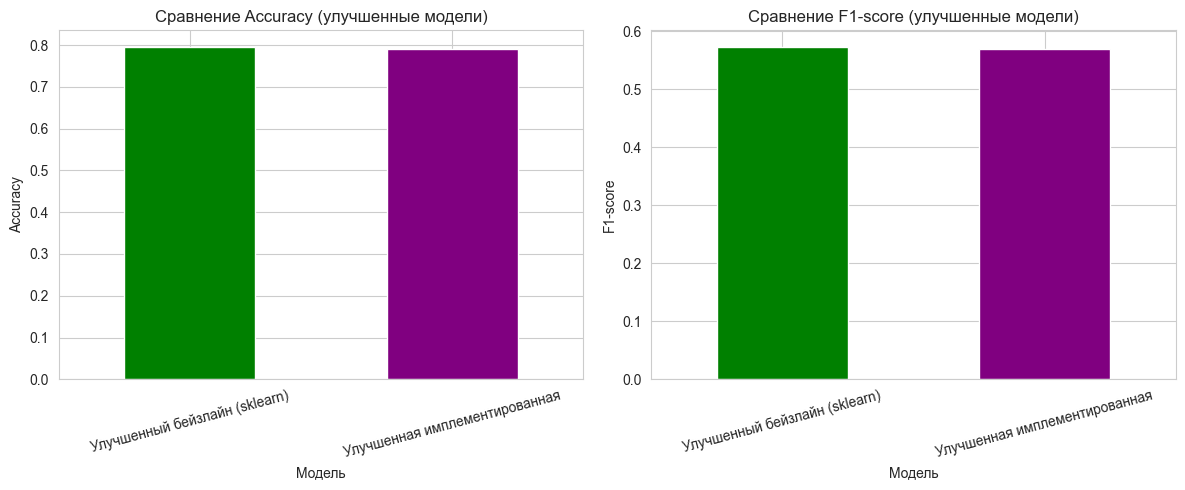

In [77]:
comparison_clf_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'Accuracy': [accuracy_clf_improved, accuracy_clf_my_improved],
    'F1-score': [f1_clf_improved, f1_clf_my_improved]
})

print("Сравнение улучшенных моделей классификации:")
print(comparison_clf_final.to_string(index=False))

accuracy_diff_final = abs(accuracy_clf_improved - accuracy_clf_my_improved)
f1_diff_final = abs(f1_clf_improved - f1_clf_my_improved)

print(f"\nРазница в Accuracy: {accuracy_diff_final:.6f}")
print(f"Разница в F1-score: {f1_diff_final:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_clf_final.plot(x='Модель', y='Accuracy', kind='bar', ax=axes[0], color=['green', 'purple'])
axes[0].set_title('Сравнение Accuracy (улучшенные модели)')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend().remove()

comparison_clf_final.plot(x='Модель', y='F1-score', kind='bar', ax=axes[1], color=['green', 'purple'])
axes[1].set_title('Сравнение F1-score (улучшенные модели)')
axes[1].set_ylabel('F1-score')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend().remove()

plt.tight_layout()
plt.show()



### Сравнение для регрессии


Сравнение улучшенных моделей регрессии:
                       Модель          MSE         MAE       R²        RMSE
Улучшенный бейзлайн (sklearn) 1.277430e+07 2791.939918 0.947418 3574.115459
Улучшенная имплементированная 1.264700e+07 2795.333728 0.947942 3556.262447

Разница в MSE: 127298.720074
Разница в MAE: 3.393809
Разница в R²: 0.000524


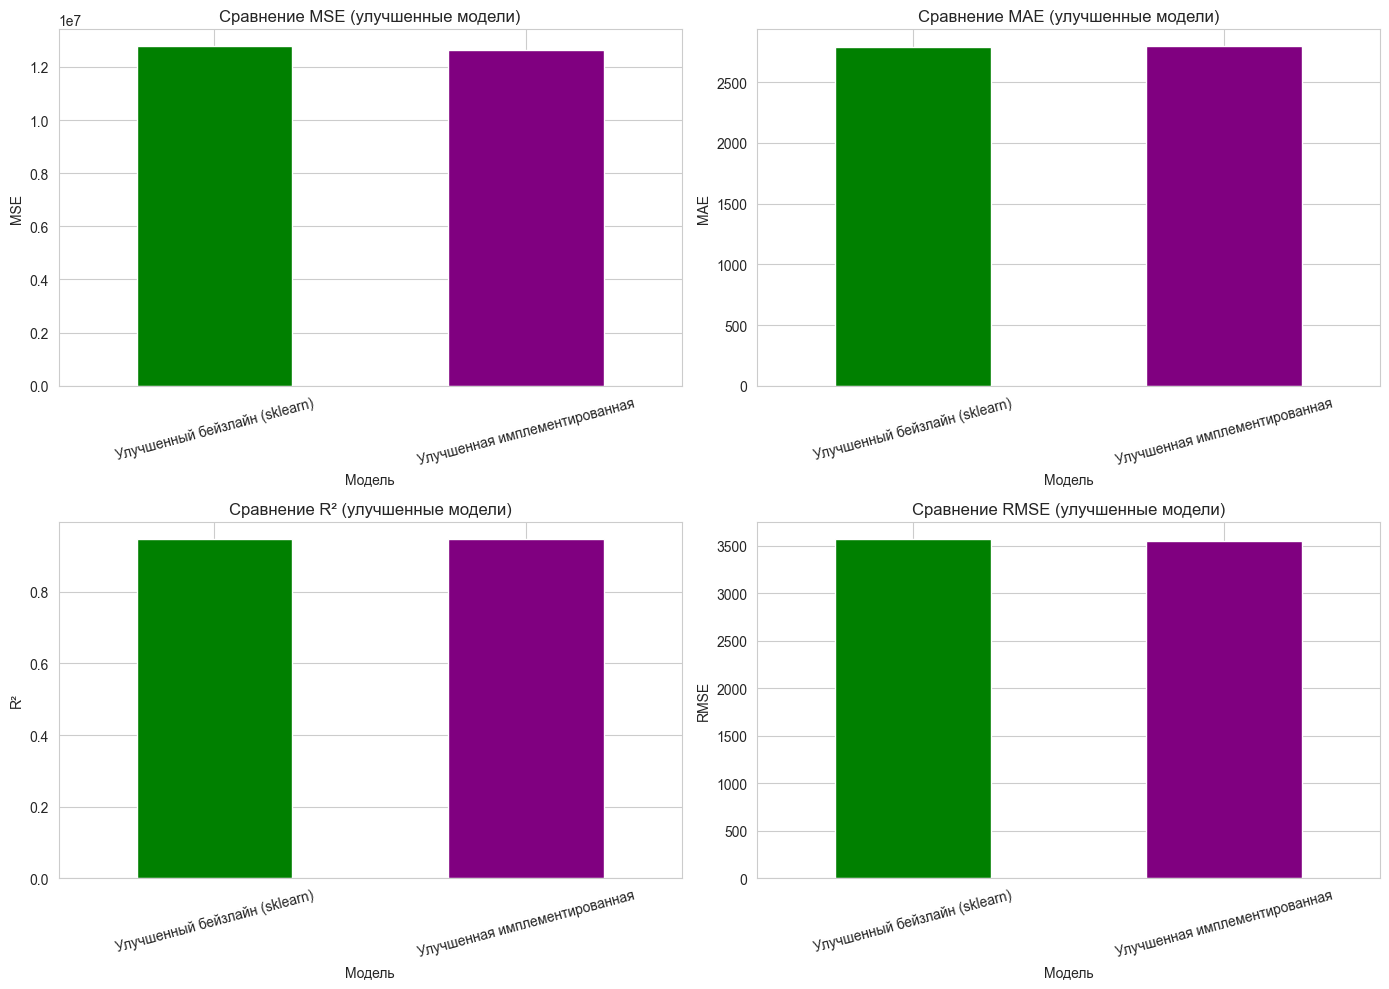

In [78]:
comparison_reg_final = pd.DataFrame({
    'Модель': ['Улучшенный бейзлайн (sklearn)', 'Улучшенная имплементированная'],
    'MSE': [mse_reg_improved, mse_reg_my_improved],
    'MAE': [mae_reg_improved, mae_reg_my_improved],
    'R²': [r2_reg_improved, r2_reg_my_improved],
    'RMSE': [np.sqrt(mse_reg_improved), np.sqrt(mse_reg_my_improved)]
})

print("Сравнение улучшенных моделей регрессии:")
print(comparison_reg_final.to_string(index=False))

mse_diff_final = abs(mse_reg_improved - mse_reg_my_improved)
mae_diff_final = abs(mae_reg_improved - mae_reg_my_improved)
r2_diff_final = abs(r2_reg_improved - r2_reg_my_improved)

print(f"\nРазница в MSE: {mse_diff_final:.6f}")
print(f"Разница в MAE: {mae_diff_final:.6f}")
print(f"Разница в R²: {r2_diff_final:.6f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

comparison_reg_final.plot(x='Модель', y='MSE', kind='bar', ax=axes[0, 0], color=['green', 'purple'])
axes[0, 0].set_title('Сравнение MSE (улучшенные модели)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='MAE', kind='bar', ax=axes[0, 1], color=['green', 'purple'])
axes[0, 1].set_title('Сравнение MAE (улучшенные модели)')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].legend().remove()

comparison_reg_final.plot(x='Модель', y='R²', kind='bar', ax=axes[1, 0], color=['green', 'purple'])
axes[1, 0].set_title('Сравнение R² (улучшенные модели)')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend().remove()

comparison_reg_final.plot(x='Модель', y='RMSE', kind='bar', ax=axes[1, 1], color=['green', 'purple'])
axes[1, 1].set_title('Сравнение RMSE (улучшенные модели)')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].legend().remove()

plt.tight_layout()
plt.show()

